# Tarefa 02

- Leia os enunciados com atenção
- Saiba que pode haver mais de uma resposta correta
- Insira novas células de código sempre que achar necessário
- Em caso de dúvidas, procure os monitores
- Divirta-se :)

#### 1. Carregue os dados da tarefa anterior

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import subprocess

from pathlib import Path

In [12]:
cwd = Path.cwd()

# procurar a pasta dados_ativos
candidatos = []
for p in [cwd] + list(cwd.parents)[:5]:
    candidatos.extend([x for x in p.glob("**/dados_ativos") if x.is_dir()])

def conta_csv(pasta: Path) -> int:
    return len([f for f in pasta.iterdir() if f.is_file() and f.suffix.lower() == ".csv"])

candidatos_com_csv = [(p, conta_csv(p)) for p in candidatos if conta_csv(p) > 0]
if not candidatos_com_csv:
    raise FileNotFoundError("Não encontrei nenhuma pasta 'dados_ativos' com arquivos .csv a partir do diretório do notebook.")

pasta_saida, n_csv = sorted(candidatos_com_csv, key=lambda x: x[1], reverse=True)[0]
arquivos = sorted([f for f in pasta_saida.iterdir() if f.is_file() and f.suffix.lower() == ".csv"])

print(f"Pasta encontrada: {pasta_saida} | CSVs: {n_csv}")

# lê e concatena
lista = []
for arq in arquivos:
    df = pd.read_csv(arq)

    ticker_arquivo = arq.stem.replace("_", ".")  # ex.: VALE3_SA -> VALE3.SA

    # garante Ticker e remove NaN misturando tipos
    if "Ticker" not in df.columns:
        df["Ticker"] = ticker_arquivo
    else:
        df["Ticker"] = df["Ticker"].fillna(ticker_arquivo)

    df["Ticker"] = df["Ticker"].astype(str).str.strip()

    # garante Date
    df["Date"] = pd.to_datetime(df["Date"])
    lista.append(df)

dados = pd.concat(lista, ignore_index=True).sort_values(["Ticker", "Date"])

ativos = sorted(dados["Ticker"].dropna().unique())
print(f"Total de linhas carregadas: {dados.shape[0]} | Ativos: {ativos}")
dados.head()


Pasta encontrada: C:\Users\Priscila\Desktop\EBAC - DATA SCIENCE\Gestão avançada de Dados e Desenvolvimento de aplicações\Descritiva III - Gráficos interativos\Pratique I\dados_ativos | CSVs: 3
Total de linhas carregadas: 1512 | Ativos: ['ITUB4.SA', 'PETR4.SA', 'VALE3.SA']


,Date,Close,High,Low,Open,Volume,Ticker
1,2024-02-14,24.846975326538086,24.955666514561674,24.723790101022654,24.78175998736103,14313415,ITUB4.SA
2,2024-02-15,25.057106018066406,25.093337970970662,24.738276420219705,24.912182904169956,32298657,ITUB4.SA
3,2024-02-16,25.028120040893555,25.209275100157903,24.839721096800687,25.1295657466287,25879532,ITUB4.SA
4,2024-02-19,25.30347442626953,25.317966894011803,25.035367687804627,25.057105606464617,32035461,ITUB4.SA
5,2024-02-20,25.854183197021484,26.04982761816062,25.28173927111648,25.28173927111648,62343778,ITUB4.SA


#### 2. Média móvel

1. Faça uma média móvel  em 90 dias dos valores de fechamento ajustados dos ativos que você escolheu
2. Utilizando a fução ```rolling()```, calcule o desvio pardão desses ativos ao longo do tempo, utilizando a mesma janela móvel do item acima
2. Monte um gráfico de linhas para as médias móveis dos ativos da sua base
4. Monte um gráfico de linhas para os desvios padrão em janela móvel
5. Compare os dois gráficos que você fez com o da tarefa anterior. Veja se eles apontam conclusões semelhantes quanto aos períodos de maior volatilidade (variação) dos ativos.

Coluna usada para o item 2 (fechamento): Close | Janela rolling: 90 dias


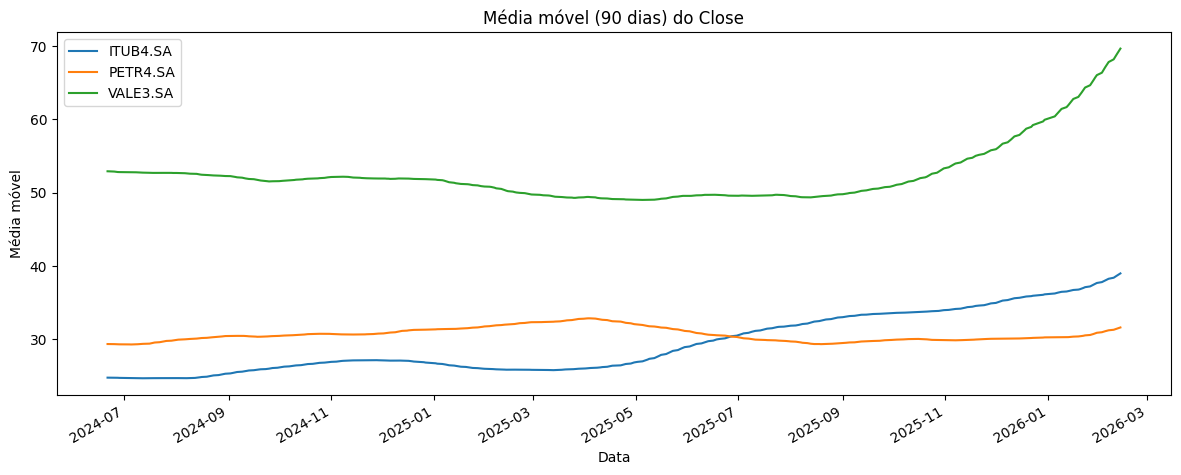

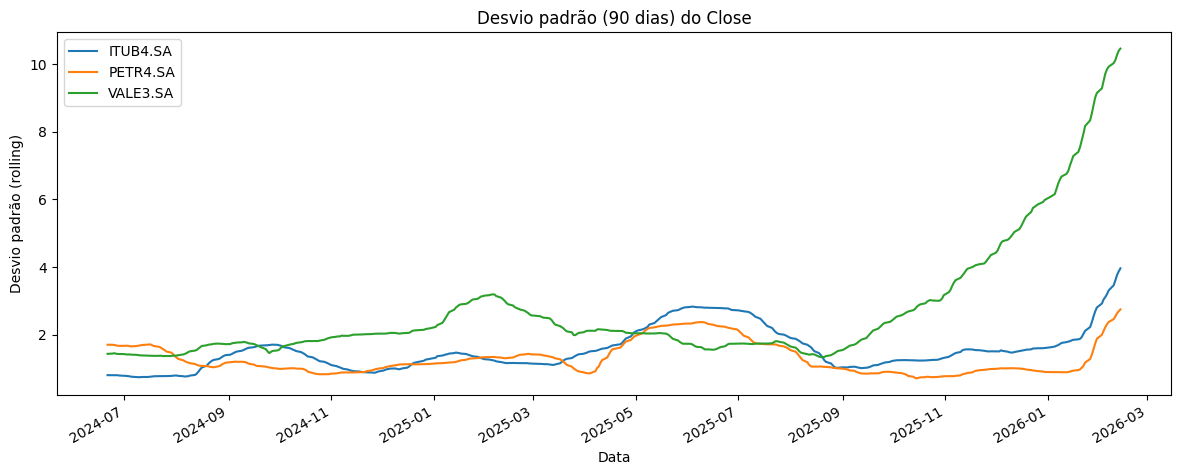

Comparação feita: correlação alta e picos próximos sugerem conclusões semelhantes sobre períodos de maior volatilidade.


,Ticker,Corr_STD90_vs_Amplitude,Data_Pico_STD90,Data_Pico_Amplitude
2,VALE3.SA,0.606063,2026-02-13,2026-01-26
0,ITUB4.SA,0.393586,2026-02-13,2025-12-05
1,PETR4.SA,0.066754,2026-02-13,2025-04-09


In [18]:
# 0) Garantir colunas numéricas (estão como string no seu CSV)
cols_numericas = ["Open", "High", "Low", "Close", "Volume", "Adj Close"]
for c in cols_numericas:
    if c in dados.columns:
        dados[c] = pd.to_numeric(dados[c], errors="coerce")

# Remover linhas sem preço/alta/baixa (evita NaN atrapalhando)
dados = dados.dropna(subset=["Date", "Ticker", "Close", "High", "Low"]).copy()

col_preco = "Adj Close" if "Adj Close" in dados.columns else "Close"

# Pivot do fechamento (datas no índice, tickers em colunas)
precos = (
    dados.pivot_table(index="Date", columns="Ticker", values=col_preco, aggfunc="mean")
    .sort_index()
)

print(f"Coluna usada para o item 2 (fechamento): {col_preco} | Janela rolling: 90 dias")
precos.head()

# 1) Média móvel 90 dias
mm90 = precos.rolling(window=90).mean()

plt.figure(figsize=(12, 5))
plt.plot(mm90.index, mm90.values)
plt.title(f"Média móvel (90 dias) do {col_preco}")
plt.xlabel("Data")
plt.ylabel("Média móvel")
plt.legend(mm90.columns)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# 2) Desvio padrão rolling 90 dias (usando rolling())
std90 = precos.rolling(window=90).std()

plt.figure(figsize=(12, 5))
plt.plot(std90.index, std90.values)
plt.title(f"Desvio padrão (90 dias) do {col_preco}")
plt.xlabel("Data")
plt.ylabel("Desvio padrão (rolling)")
plt.legend(std90.columns)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# 5) Comparação com a tarefa anterior (Amplitude = High - Low)
high = dados.pivot_table(index="Date", columns="Ticker", values="High", aggfunc="mean").sort_index()
low  = dados.pivot_table(index="Date", columns="Ticker", values="Low",  aggfunc="mean").sort_index()
amp = (high - low).sort_index()

comparacao = []
for t in precos.columns:
    serie_std = std90[t].dropna()
    serie_amp = amp[t].dropna()

    comum = serie_std.index.intersection(serie_amp.index)
    corr = serie_std.loc[comum].corr(serie_amp.loc[comum])

    pico_std = serie_std.idxmax().date()
    pico_amp = serie_amp.idxmax().date()

    comparacao.append([t, corr, pico_std, pico_amp])

comparacao_df = pd.DataFrame(
    comparacao,
    columns=["Ticker", "Corr_STD90_vs_Amplitude", "Data_Pico_STD90", "Data_Pico_Amplitude"]
).sort_values("Corr_STD90_vs_Amplitude", ascending=False)

print("Comparação feita: correlação alta e picos próximos sugerem conclusões semelhantes sobre períodos de maior volatilidade.")
comparacao_df.head()



#### 3. Gráfico de *candlestick*
1. Selecione o período dos últimos 60 dias (corridos) para um dos ativos da sua base
2. Monte um gráfico de *candlestick* para esses dados.

Candlestick do ativo: VALE3.SA
Período (60 dias corridos): 2025-12-15 até 2026-02-13 | Linhas (dias úteis): 41


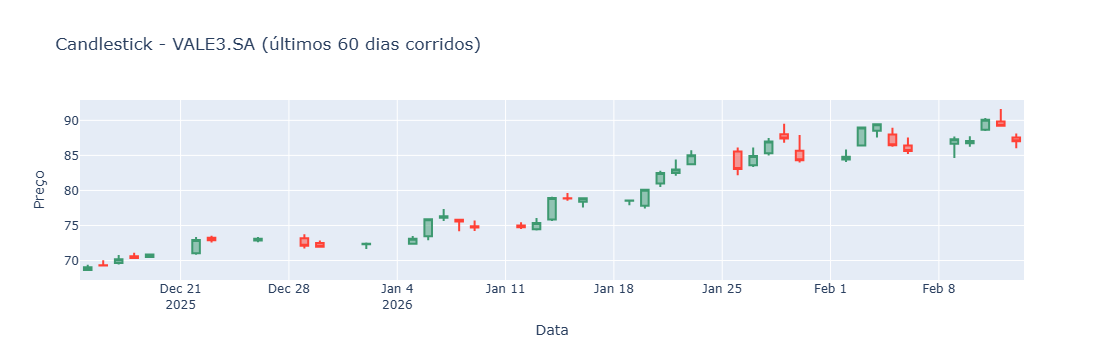

,Date,Close,High,Low,Open,Volume,Ticker
1471,2025-12-15,69.029999,69.389999,68.500000,68.650002,16841700.0,VALE3.SA
1472,2025-12-16,69.290001,70.029999,69.260002,69.330002,21953000.0,VALE3.SA
1473,2025-12-17,70.169998,70.769997,69.440002,69.639999,29375000.0,VALE3.SA
1474,2025-12-18,70.349998,71.120003,70.309998,70.599998,18430200.0,VALE3.SA
1475,2025-12-19,70.849998,70.930000,70.379997,70.500000,37147100.0,VALE3.SA


In [20]:
# ====== Escolha 1 ativo da sua base ======
ativo_candle = "VALE3.SA"  # pode trocar para "ITUB4.SA" ou "PETR4.SA"

# Garantir que preços estão numéricos (às vezes vêm como texto do CSV)
for c in ["Open", "High", "Low", "Close", "Volume"]:
    if c in dados.columns:
        dados[c] = pd.to_numeric(dados[c], errors="coerce")

# Filtrar 1 ativo e ordenar por data
df_ativo = (
    dados[dados["Ticker"] == ativo_candle]
    .dropna(subset=["Date", "Open", "High", "Low", "Close"])
    .sort_values("Date")
    .copy()
)

# Selecionar últimos 60 dias corridos (calendário)
fim = df_ativo["Date"].max()
inicio = fim - pd.Timedelta(days=60)

df_60 = df_ativo[df_ativo["Date"] >= inicio].copy()

print(f"Candlestick do ativo: {ativo_candle}")
print(f"Período (60 dias corridos): {inicio.date()} até {fim.date()} | Linhas (dias úteis): {df_60.shape[0]}")

# ====== Gráfico de candlestick (Plotly) ======
try:
    import plotly.graph_objects as go
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "plotly"])
    import plotly.graph_objects as go

fig = go.Figure(
    data=[go.Candlestick(
        x=df_60["Date"],
        open=df_60["Open"],
        high=df_60["High"],
        low=df_60["Low"],
        close=df_60["Close"]
    )]
)

fig.update_layout(
    title=f"Candlestick - {ativo_candle} (últimos 60 dias corridos)",
    xaxis_title="Data",
    yaxis_title="Preço",
    xaxis_rangeslider_visible=False
)

fig.show()

df_60.head()